## W.  Wrangling The Pronto Cycle Share datasets

### W. 1 Reading in the datasets

The Pronto Seattle cycle share data is available in 3 separate CSV files.
1. Station.csv contains data about the 58 Pronto cycle docks around Seattle - https://www.kaggle.com/pronto/cycle-share-dataset/data
2. Trip.csv contains data about every trip taken using the Pronto Cycle share system in Seattle from 2014 to 2016 - https://www.kaggle.com/pronto/cycle-share-dataset/data
3. Weather.csv contains data about the weather in Seattle that corresponds to the dates of the recorded trips in Seattle in the Trip.csv file - https://www.kaggle.com/pronto/cycle-share-dataset/data

Each of the 3 CSV files have been read into separate pandas dataframes. 

The CSV files are freely available to anyone who wants to use them on Kaggle Datasets - https://www.kaggle.com/datasets

In [1]:
import pandas as pd

#Importing and reading csv files directly into pandas dataframe

station_data = pd.read_csv('station.csv')

trip_data = pd.read_csv('trip.csv', error_bad_lines=False)

weather_data = pd.read_csv('weather.csv')

b'Skipping line 50794: expected 12 fields, saw 20\n'


**Note: The trip.csv file contained a corrupted line which had to be skipped for the data to be successfully read into pandas DataFrame**

### W.2 Cleaning the Station Data Set 


In [2]:
#Information about the various colums in the station_data DataFrame
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
station_id           58 non-null object
name                 58 non-null object
lat                  58 non-null float64
long                 58 non-null float64
install_date         58 non-null object
install_dockcount    58 non-null int64
modification_date    17 non-null object
current_dockcount    58 non-null int64
decommission_date    4 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 4.2+ KB


 - **The station dataset contains a column for modification_date of a station which contains the date on which the station dock was modified to hold more or less cycles and null values if the station was never modified after it was initially set up. I will drop this column entirely as it contains only 17 non_null values and does not provide us with information that would be useful for our analysis.**


- **The dataset also contains an install_dockcount column which contains the cycle holding capacity of the dock at a station when it was initially set up and the current_dockcount column holds the current cycle holding capacity of a dock at a station. The current_dockcount and the install_dockcount values for a station are the same if it was never modified. Since we are only interested in current values for all stations, I will drop the install_dockcount column entirely.**


- **4 out of the 58 stations in Seattle have been decommsioned and are no longer active. I will drop these decommisioned stations from the dataset , to work with only the active stations which also makes the decommissoned_date column unecessary for our analysis and I will be able to drop it as well.**

In [3]:
#Dropping the modification_date and install_dockcount columns from the dataset
station_data = station_data.drop(['modification_date','install_dockcount'],axis=1)

In [4]:
#Extracting only those stations that were not decommisoned during the time this data was collected
active_stations = station_data['decommission_date'].isnull()
station_data = station_data.loc[active_stations]

In [5]:
#Dropping the decommision_date column from the station_data DataFrame 
station_data = station_data.drop(['decommission_date'],axis=1)

In [6]:
#Information about the columns in the cleaned station_data Dataframe
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 57
Data columns (total 6 columns):
station_id           54 non-null object
name                 54 non-null object
lat                  54 non-null float64
long                 54 non-null float64
install_date         54 non-null object
current_dockcount    54 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.0+ KB


#### Exploring the Cleaned station_data Dataframe

In [7]:
#The first five rows of the cleaned Dataframe
station_data.head(5)

,station_id,name,lat,long,install_date,current_dockcount
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18
1,BT-03,2nd Ave & Vine St,47.615829,-122.348564,10/13/2014,16
2,BT-04,6th Ave & Blanchard St,47.616094,-122.341102,10/13/2014,16
3,BT-05,2nd Ave & Blanchard St,47.613110,-122.344208,10/13/2014,14
4,CBD-03,7th Ave & Union St,47.610731,-122.332447,10/13/2014,20


### W.2 Cleaning the Trip Dataset

The trip dataset contains some null values only in 2 columns, namely 'gender' and 'birthyear'. Furthermore these null values only occur when the trip belongs to Short Term Passholder , which ranges from a 24 hour pass or a 3 day pass as offered by Pronto as compared to a trip made by someone who is a Member, which could be a monthly subscription or a yearly one to the Pronto Cycle Share.

For the purpose of cleaning the null values and for a more precise analysis, I will split the trip data set on the basis of the client being a Member or a Temporary Pass Holder into 2 separate datasets. 

In [8]:
#Information about the various columns in the trip_data Dataframe
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null object
stoptime             286857 non-null object
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 26.3+ MB


**The trip dataset contains 181,557 trips where the user was a member and 105,300 trips where the user was a Short Term Pass Holder.**

In [9]:
#Counting the number of member and short_term pass holder trips in the dataset
trip_data['usertype'].value_counts()

Member                    181557
Short-Term Pass Holder    105300
Name: usertype, dtype: int64

**To create the member only dataset, I will:**

- **Extract all the rows from the original trip dataset where the column usertype contains the value 'Member'and store it in separate dataset.**


- **Drop any rows with null value in gender or birthyear column if any remain.**


- **Drop the usertype column entirely as it has become redundant for this dataset.**

In [10]:
#Extracting information about only the member trips and storing them in a separate Dataframe
member_only = trip_data['usertype'] == 'Member'
member_trip_data = trip_data.loc[member_only]

#Dropping the 4 rows with missing values in the birthyear column from the member trip data set
birthyear_present = member_trip_data['birthyear'].notnull()
member_trip_data = member_trip_data.loc[birthyear_present]

In [11]:
#Removing the usertype column from the member trip data set since it is redundant 
member_trip_data = member_trip_data.drop(['usertype'],axis = 1)

**The new dataset 'member_trip_data' does not contain any null values in any of it's columns.**

In [12]:
member_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181553 entries, 0 to 286848
Data columns (total 11 columns):
trip_id              181553 non-null int64
starttime            181553 non-null object
stoptime             181553 non-null object
bikeid               181553 non-null object
tripduration         181553 non-null float64
from_station_name    181553 non-null object
to_station_name      181553 non-null object
from_station_id      181553 non-null object
to_station_id        181553 non-null object
gender               181553 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 16.6+ MB


In [13]:
member_trip_data.head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1971.0


** Since the dataset does not contain gender and birthyear data for the trips taken by non members and so these columns only contain null values. To get a clean dataset for Temporary Pass Holders, I will:**

- **Extract all the rows from the original trip dataset where the usertype column contains the value 'Temporary Pass Holder'**


- **Drop birthname and gender column completely as they only contain null values for non members** 


- **Drop the usertype column as it has become redundant for this dataset**

In [14]:
#Extracting the information about the Short Term Pass Holder trips and storing them in a separate Dataframe 
pholder_only = trip_data['usertype'] == 'Short-Term Pass Holder'
pholder_trip_data = trip_data.loc[pholder_only]

In [15]:
#Dropping the colums containing all null values in the pass holder and the usertype column which has become redundant 
pholder_trip_data = pholder_trip_data.drop(['usertype','gender','birthyear'],axis = 1)

**The new datset 'pholder_trip_data' does not contain any null values in any of it's columns**

In [16]:
pholder_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105300 entries, 69 to 286856
Data columns (total 9 columns):
trip_id              105300 non-null int64
starttime            105300 non-null object
stoptime             105300 non-null object
bikeid               105300 non-null object
tripduration         105300 non-null float64
from_station_name    105300 non-null object
to_station_name      105300 non-null object
from_station_id      105300 non-null object
to_station_id        105300 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 8.0+ MB


In [17]:
pholder_trip_data.head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id
69,507,10/13/2014 12:11,10/13/2014 12:16,SEA00321,332.457,City Hall / 4th Ave & James St,City Hall / 4th Ave & James St,CBD-07,CBD-07
78,518,10/13/2014 12:20,10/13/2014 12:31,SEA00321,690.793,City Hall / 4th Ave & James St,2nd Ave & Blanchard St,CBD-07,BT-05
89,530,10/13/2014 12:43,10/13/2014 12:48,SEA00311,278.849,King Street Station Plaza / 2nd Ave Extension ...,King Street Station Plaza / 2nd Ave Extension ...,PS-05,PS-05
91,533,10/13/2014 12:48,10/13/2014 12:51,SEA00269,179.939,NE 42nd St & University Way NE,12th Ave & NE Campus Pkwy,UD-02,UD-04
92,534,10/13/2014 12:48,10/13/2014 12:58,SEA00355,590.698,9th Ave N & Mercer St,Dexter Ave & Denny Way,DPD-01,SLU-18


In [18]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 21 columns):
Date                          689 non-null object
Max_Temperature_F             689 non-null int64
Mean_Temperature_F            688 non-null float64
Min_TemperatureF              689 non-null int64
Max_Dew_Point_F               689 non-null int64
MeanDew_Point_F               689 non-null int64
Min_Dewpoint_F                689 non-null int64
Max_Humidity                  689 non-null int64
Mean_Humidity                 689 non-null int64
Min_Humidity                  689 non-null int64
Max_Sea_Level_Pressure_In     689 non-null float64
Mean_Sea_Level_Pressure_In    689 non-null float64
Min_Sea_Level_Pressure_In     689 non-null float64
Max_Visibility_Miles          689 non-null int64
Mean_Visibility_Miles         689 non-null int64
Min_Visibility_Miles          689 non-null int64
Max_Wind_Speed_MPH            689 non-null int64
Mean_Wind_Speed_MPH           689 non-null int64
Max_

### Visualizing Collinearity between feature variables 

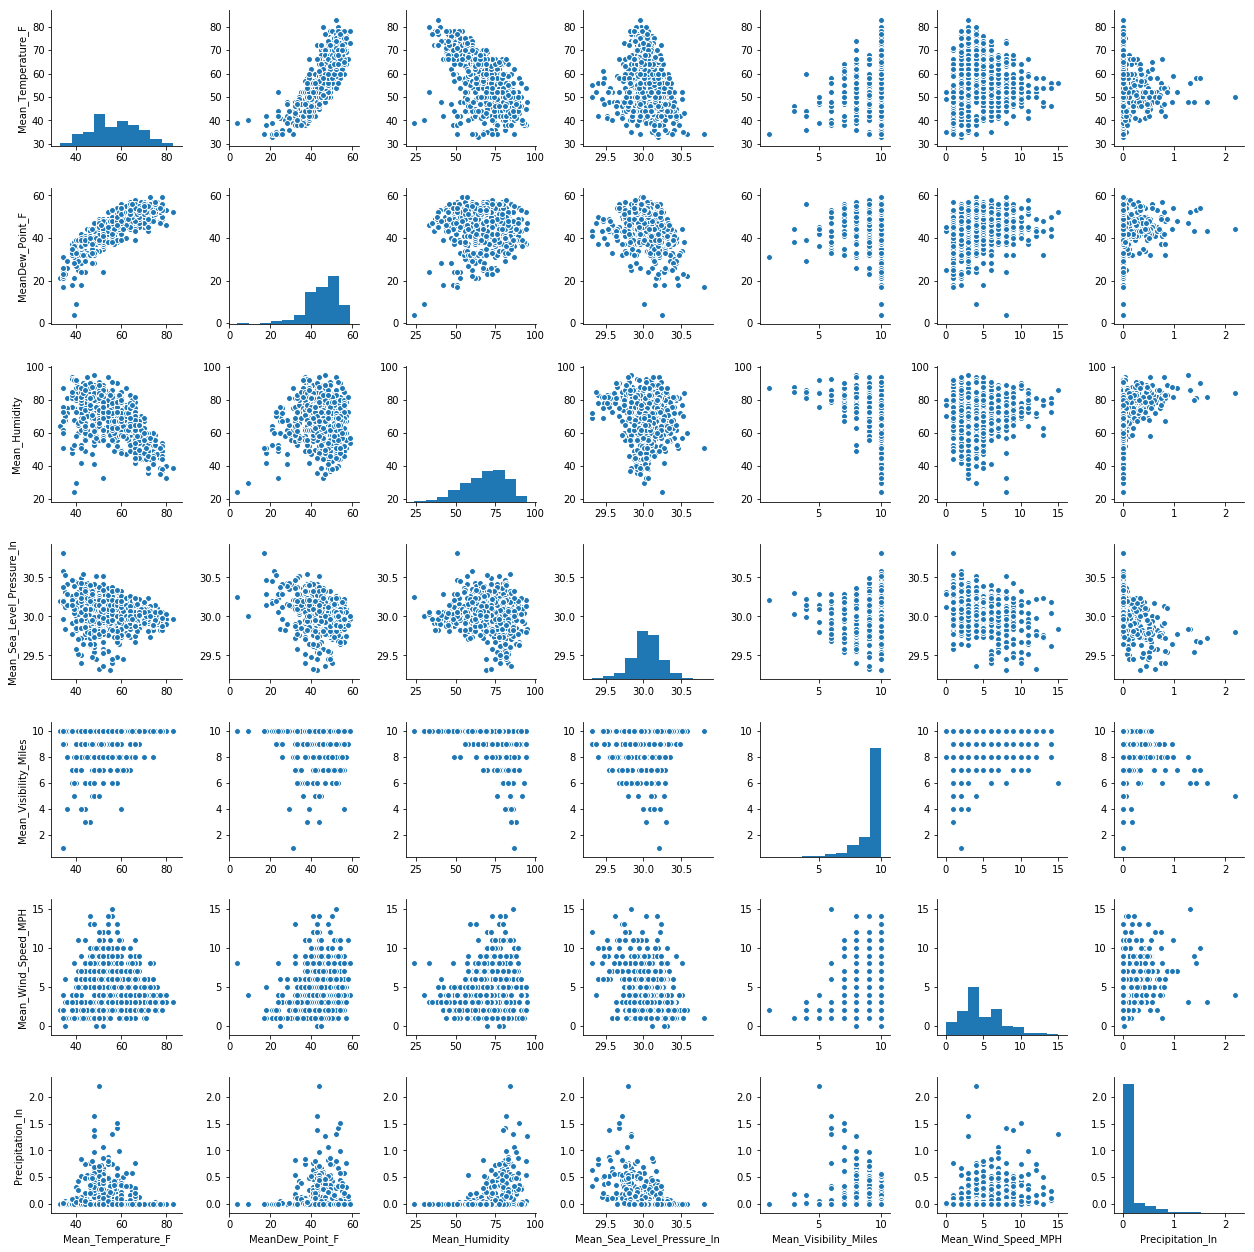

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns 
weather_data_test = weather_data[['Mean_Temperature_F','MeanDew_Point_F','Mean_Humidity','Mean_Sea_Level_Pressure_In',
                                  'Mean_Visibility_Miles','Mean_Wind_Speed_MPH','Precipitation_In']]
weather_data_test = weather_data_test.dropna(axis=0,how='any')
sns.pairplot(weather_data_test)
plt.show()

In [20]:
corr_mat = weather_data_test.corr()
corr_mat

,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity,Mean_Sea_Level_Pressure_In,Mean_Visibility_Miles,Mean_Wind_Speed_MPH,Precipitation_In
Mean_Temperature_F,1.000000,0.813847,-0.584973,-0.174619,0.322032,-0.018131,-0.194528
MeanDew_Point_F,0.813847,1.000000,-0.026806,-0.280512,0.092581,0.151102,0.043741
Mean_Humidity,-0.584973,-0.026806,1.000000,-0.092312,-0.465319,0.218338,0.420898
Mean_Sea_Level_Pressure_In,-0.174619,-0.280512,-0.092312,1.000000,0.099685,-0.323129,-0.447917
Mean_Visibility_Miles,0.322032,0.092581,-0.465319,0.099685,1.000000,0.024214,-0.403926
Mean_Wind_Speed_MPH,-0.018131,0.151102,0.218338,-0.323129,0.024214,1.000000,0.308893
Precipitation_In,-0.194528,0.043741,0.420898,-0.447917,-0.403926,0.308893,1.000000


#### Merging and groupig trips and weather dataset to build feature and target variables for our regression models

In [21]:
from datetime import datetime

#Extracting required columns from the trip_data dataset
trips = trip_data[['trip_id','starttime']]

#Writing a function that converst starttime column from trip_data to datetime object
def dt_convert(s):
    try:
        dt = s[:-6]
        return datetime.strptime(dt,'%m/%d/%Y')
    except:
        dt = s[:-5]
        return datetime.strptime(dt,'%m/%d/%Y')
    
#Creating a new column 'date' from starrtime by applying dt_convert()
trips['date'] = trips['starttime'].apply(dt_convert)


#Extracting required columns from the weather_data dataset
weather = weather_data[['Date','Mean_Temperature_F','Mean_Humidity','Mean_Sea_Level_Pressure_In',
                        'Mean_Visibility_Miles','Mean_Wind_Speed_MPH','Precipitation_In']]

#Writing a function that converst Date column from weather_data to datetime object
def dt_conv_simp(s):
    return datetime.strptime(s,'%m/%d/%Y')

##Creating a new column 'date' from starrtime by applying dt_conv_simp()
weather['date'] = weather['Date'].apply(dt_conv_simp)

#Dropping 'starttime' and 'Date' columns from trips and weather resectively
trips = trips.drop(['starttime'],axis=1)
weather = weather.drop(['Date'],axis=1)

#Merging trips and weather dataset on date column
trips_weather = pd.merge(trips,weather, on='date')

#Grouping the dataframe to get trips per day with weather stats about that day
trips_weather_group = trips_weather.groupby(['date','Mean_Temperature_F','Mean_Humidity','Mean_Sea_Level_Pressure_In',
                        'Mean_Visibility_Miles','Mean_Wind_Speed_MPH','Precipitation_In'])
trips_weather_count = trips_weather_group['trip_id'].count()
trips_weather_count = pd.DataFrame(trips_weather_count).reset_index()
trips_weather_count.columns = ['Date','Mean_Temp','Mean_Humid','Mean_Sea_Press','Mean_Visib',
                               'Mean_Wind','Percepitation','Trip_Count']

def calc_day(dt:'datetime object'):
    return dt.weekday()

trips_weather_count['Day'] = trips_weather_count['Date'].apply(calc_day)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
trips_weather_count.head()

,Date,Mean_Temp,Mean_Humid,Mean_Sea_Press,Mean_Visib,Mean_Wind,Percepitation,Trip_Count,Day
0,2014-10-13,62.0,68,29.79,10,4,0.00,818,0
1,2014-10-14,59.0,78,29.75,9,5,0.11,982,1
2,2014-10-15,58.0,77,29.71,9,7,0.45,626,2
3,2014-10-16,61.0,61,29.95,10,4,0.00,790,3
4,2014-10-17,60.0,72,29.78,10,3,0.14,588,4


In [23]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

m = ols('Trip_Count ~ Mean_Temp + Mean_Humid + Mean_Sea_Press + Mean_Visib + Mean_Wind \
        + Percepitation + Day',trips_weather_count).fit()
print(m.summary())

/home/ec2-user/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:             Trip_Count   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     48.14
Date:                Fri, 05 Jan 2018   Prob (F-statistic):           1.55e-55
Time:                        09:32:38   Log-Likelihood:                -4451.0
No. Observations:                 688   AIC:                             8918.
Df Residuals:                     680   BIC:                             8954.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2226.5970   1114.526     -1.

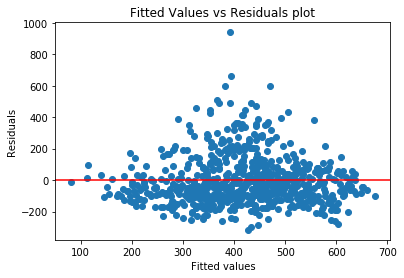

In [24]:
#Plotting the fitted values vs residuals plot 
plt.scatter(m.fittedvalues,m.resid)
plt.axhline(0,color='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals plot')
plt.show()

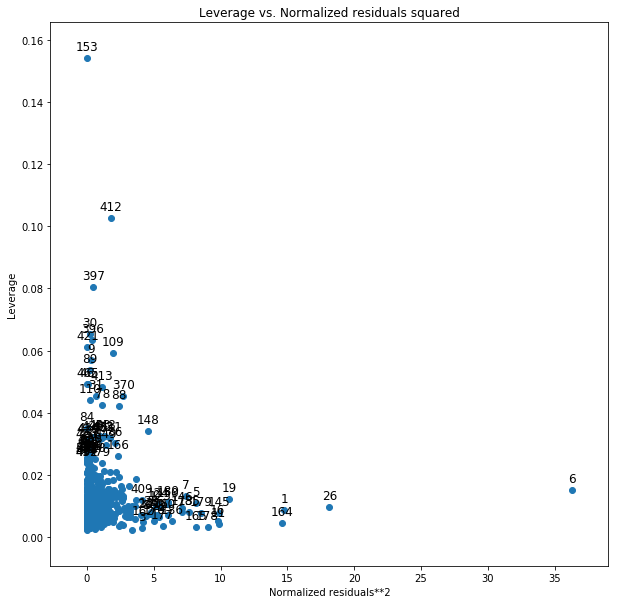

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
fig = sm.graphics.plot_leverage_resid2(m,ax=ax)
plt.show()

In [26]:
trips_weather_count_e = trips_weather_count.drop([6,26,164,1,148,88,370,78,110,31,413,4,16,65,89,9,109,421,
                                                 396,30,397,412,153])
n = ols('Trip_Count ~ Mean_Temp + Mean_Humid + Mean_Sea_Press + Mean_Visib + Mean_Wind \
        + Percepitation + Day',trips_weather_count_e).fit()
print(n.summary())

                            OLS Regression Results                            
Dep. Variable:             Trip_Count   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     53.70
Date:                Fri, 05 Jan 2018   Prob (F-statistic):           1.37e-60
Time:                        09:32:39   Log-Likelihood:                -4252.4
No. Observations:                 665   AIC:                             8521.
Df Residuals:                     657   BIC:                             8557.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2976.3577   1076.323     -2.

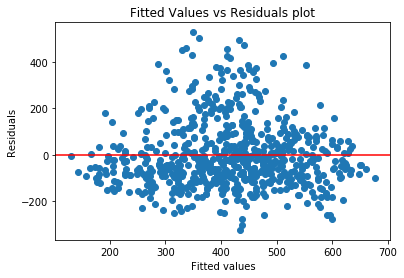

In [27]:
plt.scatter(n.fittedvalues,n.resid)
plt.axhline(0,color='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals plot')
plt.show()

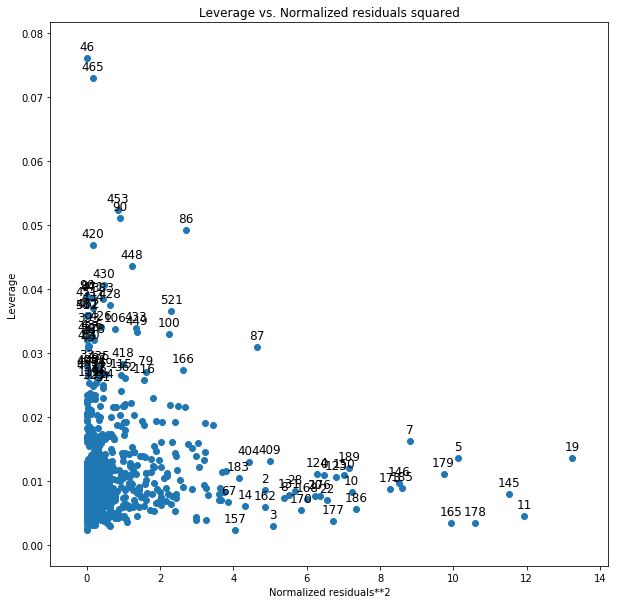

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
fig = sm.graphics.plot_leverage_resid2(n,ax=ax)
plt.show()

In [29]:
trips_weather_count_e = trips_weather_count_e.drop([11,19,145,178,165,179,5,173,185,146,7,173,177,186,10,189,150,123,
                                                   22,124,0,170,168,87,100,521,448,420,90,86,453,465,46])
o = ols('Trip_Count ~ Mean_Temp + Mean_Humid + Mean_Sea_Press + Mean_Visib + Mean_Wind \
        + Percepitation + Day',trips_weather_count_e).fit()
print(o.summary())

                            OLS Regression Results                            
Dep. Variable:             Trip_Count   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     72.15
Date:                Fri, 05 Jan 2018   Prob (F-statistic):           2.96e-76
Time:                        09:32:39   Log-Likelihood:                -3944.7
No. Observations:                 633   AIC:                             7905.
Df Residuals:                     625   BIC:                             7941.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2537.0253    940.081     -2.

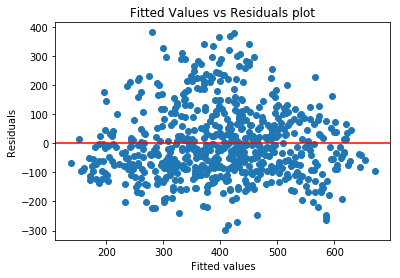

In [30]:
plt.scatter(o.fittedvalues,o.resid)
plt.axhline(0,color='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals plot')
plt.show()

### Linear Regression Model

In [31]:
#Fitting scikit learn Linear Regression model on our data to compare results
#with statsmodel.api models
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
#Converting feature variables and target variables to numpy arrays
X = np.array(trips_weather_count_e.drop(['Trip_Count','Date'],axis=1))
y = np.array(trips_weather_count_e['Trip_Count'])
y1 = y.reshape(-1,1)
#Initializing and fitting the model
lr_model = LinearRegression()
lr_model.fit(X,y1)
#Printing the necessary results
print('R-squared for Scikit Learn Linear Regression Model:')
print(lr_model.score(X,y1))
#Printing mean squared error
MRSE = mean_squared_error(y1,lr_model.predict(X))
print('Mean Squared Error for Scikit Learn Linear Regression Model')
print(MRSE)

R-squared for Scikit Learn Linear Regression Model:
0.446928471437
Mean Squared Error for Scikit Learn Linear Regression Model
15146.7958733


### Ridge Regression Model

In [32]:
#Fitting a ridge regression model on the data 
from sklearn.linear_model import RidgeCV
ridge_reg = RidgeCV(alphas=[0.01,0.1,0.5,1])
ridge_reg.fit(X,y1)
print('Best Alpha:',ridge_reg.alpha_)
print('Best R-squared:',ridge_reg.score(X,y1))
print('Coefficients:',ridge_reg.coef_)
#Printing the results
MRSE = mean_squared_error(y1,ridge_reg.predict(X))
print('MRSE:',MRSE)

Best Alpha: 1.0
Best R-squared: 0.446887835609
Coefficients: [[   4.2688242    -4.89452669  102.70714612  -10.42546586   -6.62320758
   -79.75775299  -11.70970349]]
MRSE: 15147.9087539


### Lasso Regression Model

In [33]:
#Fitting a lasso regression model on our data 
from sklearn.linear_model import LassoCV
lasso_reg = LassoCV(alphas=[0.01,0.1,0.5,1,10])
lasso_reg.fit(X,y)
print('Best Alpha:',lasso_reg.alpha_)
print('Best R-squared:',lasso_reg.score(X,y))
print('Coefficients:',lasso_reg.coef_)
#Printing the results
MRSE = mean_squared_error(y,lasso_reg.predict(X))
print('MRSE:',MRSE)

Best Alpha: 10.0
Best R-squared: 0.419796348521
Coefficients: [  3.5466425   -5.4086813    0.          -0.          -8.78465962  -0.
 -10.5166715 ]
MRSE: 15889.8547838


### Elastic Net Model

In [34]:
#Fitting an Elastic Net model on our data
from sklearn.linear_model import ElasticNetCV
elastic_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],alphas=[0.01,0.1,0.5,1,10])
elastic_net.fit(X,y)
print('Best Alpha:',elastic_net.alpha_)
print('Best L1 ratio:',elastic_net.l1_ratio_)
print('Best R-squared',elastic_net.score(X,y1))
print('Coefficients:',elastic_net.coef_)
#Printing the results
MRSE = mean_squared_error(y,elastic_net.predict(X))
print('MRSE:',MRSE)

Best Alpha: 10.0
Best L1 ratio: 0.1
Best R-squared 0.4006656751
Coefficients: [ 3.34847253 -5.47562399  0.47624143 -0.         -4.5326809  -0.34329387
 -4.04189823]
MRSE: 16413.7805154


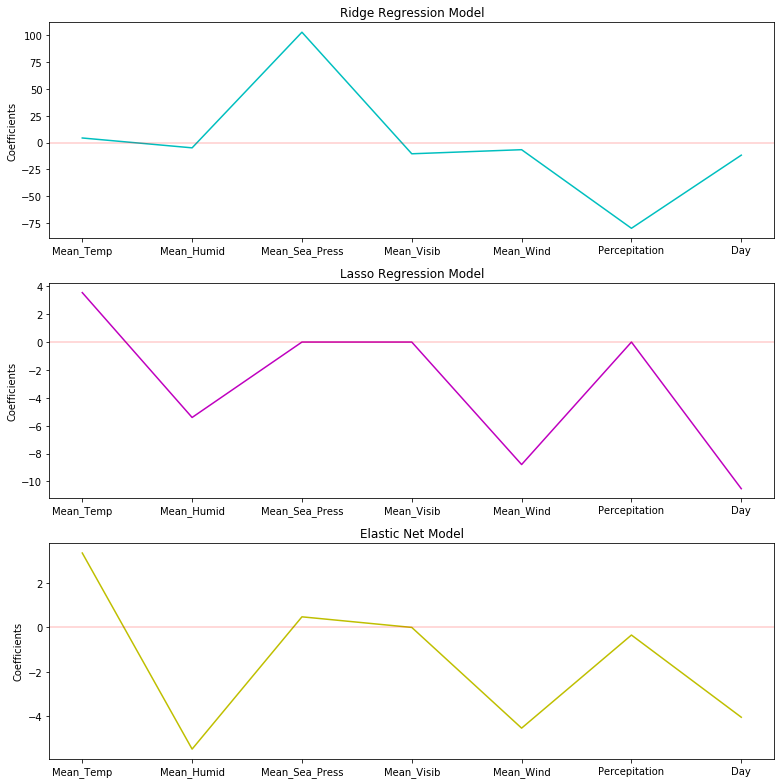

In [35]:
#Plotting the coeffiecients assigned to each feature variable by each of the fitted models
features = list(trips_weather_count_e.columns)
features = features[1:-2]
features.append('Day')


fig, ax = plt.subplots(figsize=(11,11))
#Dividing the graph into subplots
plt.subplot(3,1,1)
plt.plot(range(len(features)),ridge_reg.coef_.reshape(-1,1),color='c')
plt.axhline(0,color='red',alpha=0.2)
plt.xticks(range(len(features)),features)
plt.ylabel('Coefficients')
plt.title('Ridge Regression Model')


plt.subplot(3,1,2)
plt.plot(range(len(features)),lasso_reg.coef_,color='m')
plt.axhline(0,color='red',alpha=0.2)
plt.xticks(range(len(features)),features)
plt.ylabel('Coefficients')
plt.title('Lasso Regression Model')


plt.subplot(3,1,3)
plt.plot(range(len(features)),elastic_net.coef_,color='y')
plt.axhline(0,color='red',alpha=0.2)
plt.xticks(range(len(features)),features)
plt.ylabel('Coefficients')
plt.title('Elastic Net Model')

plt.tight_layout()
plt.show()

In [36]:
#Extracting necessary columns from the member_only_trip dataset to be used to fit the classification model
member_model = member_trip_data[['from_station_name','gender','birthyear','to_station_name']]
#Function that calculates age from birthyear column in the member_only_trip dataset
def calc_age(year):
    return 2016 - year
#Applying calc_age function to create a new column and dropping columns that are no longer necesary
member_model['age'] = member_model['birthyear'].apply(calc_age)
member_model_b = member_model.drop(['birthyear','to_station_name'],axis=1)
#Converting all categorical variables to continous(binary) using pandas get_dummies method
member_model_c = pd.get_dummies(member_model_b)
#Dropping one column of each converted feature to avoid double counting
member_model_d = member_model_c.drop(['from_station_name_12th Ave & E Denny Way','gender_Other'],axis=1)
#Converting all feature variables and target variables to numpy to fit the classification models
X = np.array(member_model_d)
y = np.array(member_model['to_station_name'].values)
#Importing necessary Scikit learn libraries and classes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
#Initializng the KNN model
knn = KNeighborsClassifier()

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


"\nknn = KNeighborsClassifier()\n\nparam_grid = {'n_neighbors':np.array([3,5,7,10,12])}\n\nknn_cv = GridSearchCV(knn,param_grid,cv=5)\n\nknn_cv.fit(X_train,y_train)\n\nprint(knn_cv.best_params_)\nprint(knn_cv.best_score_)\n"

### Further wrangling on the above dataset - member_model_d

In [39]:
#function that extracts day as an integer from a datetime object
def get_day(s):
    try:
        dt = s[:-6]
        return datetime.strptime(dt,'%m/%d/%Y').weekday()
    except:
        dt = s[:-5]
        return datetime.strptime(dt,'%m/%d/%Y').weekday()
#function that extracts hour according to the 24 hour clock from a datetime object    
def get_hour(s):
    try:
        dt = s
        return datetime.strptime(dt,'%m/%d/%Y %H:%M').hour
    except:
        dt = s
        return datetime.strptime(dt,'%m/%d/%Y %H:%M').hour
#Applying aformentioned functions to the datetime column and storing the results in new separate columns
test_df = member_model_d
test_df['day'] = member_trip_data['starttime'].apply(get_day)
test_df['hour'] = member_trip_data['starttime'].apply(get_hour)
#Converting the feature variables and target variables to numpy arrays
X = np.array(test_df)
y = np.array(member_model['to_station_name'].values)
#Splitting the data into test and training sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### K-Nearest Neighbor Model

In [632]:
#5 fold CV using GridSearch CV
param_grid = {'n_neighbors':np.array([2,3,4,5,6,7])}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)
#Printing optimal value for K and best associated accuracy score
print(knn_cv.best_params_)
print(knn_cv.best_score_)

/Users/sam/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'n_neighbors': 2}
0.44657192823


In [634]:
#Accuracy on hold out set with optimal K = 2
knn_cv.score(X_test,y_test)

0.46630497645341634

In [635]:
#5 fold CV using GridSearch CV with broader range of values for K
param_grid = {'n_neighbors':np.array([7,8,9,10,11,12])}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)
#Printing optimal value for K and best associated accuracy score
print(knn_cv.best_params_)
print(knn_cv.best_score_)

/Users/sam/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'n_neighbors': 7}
0.440382258575


In [636]:
#Accuracy on hold out set with optimal K = 7
knn_cv.score(X_test,y_test)

0.45484839304893832

In [637]:
#Creating a plot to show accuracy on training and testing sets for various values of K
neighbors = np.array([1,2,3,4,5,6,7,8,9,10])
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train,y_train)
    test_accuracy[i] = knn.score(X_test,y_test)

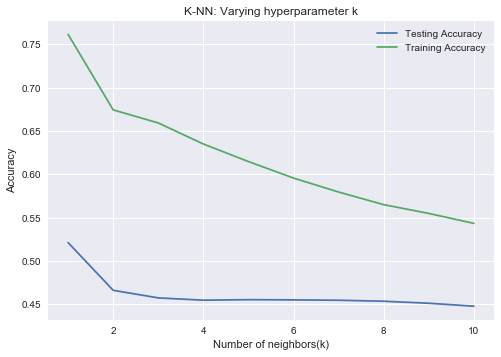

In [638]:
#Passing necessary arguements and labelling the axes to show the plot
plt.title('K-NN: Varying hyperparameter k')
plt.plot(neighbors,test_accuracy,label='Testing Accuracy')
plt.plot(neighbors,train_accuracy,label='Training Accuracy')
plt.legend()
plt.xlabel('Number of neighbors(k)')
plt.ylabel('Accuracy')
plt.show()

### XGB Classifier

In [40]:
#Importing necessary modules
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

#Defining a function that takes XGB model wrapper, feature variables and target variables as arguements and 
#performs 5 fold cv at every step till test error does not decrease for 3 rounds.
def modelFit(alg, X, y, useTrainCV=True, cvFolds=5, early_stopping_rounds=3):
    if useTrainCV:
        xgbParams = alg.get_xgb_params()
        xgbParams['num_class'] = 60
        xgTrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgbParams,
                      xgTrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=cvFolds,
                      stratified=True,
                      metrics={'merror'},
                      early_stopping_rounds=early_stopping_rounds,
                      seed=0,
                      callbacks=[xgb.callback.print_evaluation(show_stdv=False),xgb.callback.early_stop(3)])

        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm
    alg.fit(X, y)

    # Predict
    dtrainPredictions = alg.predict(X)
    dtrainPredProb = alg.predict_proba(X)

    # Print model report:
    print("\nModel Report")
    print("Classification report: \n")
    print(classification_report(y_val, y_val_pred))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Note: Since the output generated from tuning the model for n_parameteres is extremely large and we are only interested in the best iteration, I will remove the generated output and manually input the values for best iteration. 

In [42]:
#Encoding target variables using LabelEncoder as XGB Classifier only works with continous variables
encoder = LabelEncoder()
y_e = encoder.fit_transform(y)
X_train_e,X_test_e,y_train_e,y_test_e = train_test_split(X,y_e,test_size=0.2,random_state=42)
#Initializing XGB Classifier 
xgb1 = XGBClassifier(
learning_rate = 0.1,
n_estimators=1000,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27)
#Fitting the model using the aformetioned function
modelFit(xgb1,X_train_e,y_train_e)

Best Iteration: 370  test merror: 0.387533 train merror: 0.514567

#### Tuning max_depth and min_child_weight

In [102]:
param_test_1 = {'max_depth':list(range(3,10,2)),
               'min_child_weight':list(range(1,6,2))}

gsearch1 =  GridSearchCV(estimator = XGBClassifier(
learning_rate = 0.1,
n_estimators=370,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27),param_grid = param_test_1,n_jobs=12,iid=False, cv=5)

gsearch1.fit(X_train_e,y_train_e)
print(gsearch1.best_params_, gsearch1.best_score_)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


{'max_depth': 9, 'min_child_weight': 1} 0.5316430898017968


In [40]:
param_test_2 = {'max_depth':[8,9,10],
               'min_child_weight':[1,2]}

gsearch2 =  GridSearchCV(estimator = XGBClassifier(
learning_rate = 0.1,
n_estimators=370,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27),param_grid = param_test_2,n_jobs=6,iid=False, cv=5)

gsearch2.fit(X_train_e,y_train_e)
print(gsearch2.best_params_, gsearch2.best_score_)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


{'max_depth': 10, 'min_child_weight': 1} 0.5376609009511389


#### Tuning gamma

In [40]:
param_test_3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 =  GridSearchCV(estimator = XGBClassifier(
learning_rate = 0.1,
n_estimators=370,
max_depth=10,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27),param_grid = param_test_3,n_jobs=5,iid=False, cv=5)

gsearch3.fit(X_train_e,y_train_e)

print(gsearch3.best_params_, gsearch3.best_score_)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


{'gamma': 0.1} 0.538170378330838


#### Re-tuning for n_learners with new values of the hyper parameters tuned above

In [1]:
xgb2 = XGBClassifier(
learning_rate = 0.1,
n_estimators=1000,
max_depth=10,
min_child_weight=1,
gamma=0.1,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27)

modelFit(xgb2,X_train_e,y_train_e)

Best iteration 296 train-merror:0.30611	 test-merror:0.466642

#### Tuning subsample and colsample_bytree

In [41]:
param_test_4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(7,11)]
}

gsearch4 =  GridSearchCV(estimator = XGBClassifier(
learning_rate = 0.1,
n_estimators=296,
max_depth=10,
min_child_weight=1,
gamma=0.1,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27),param_grid = param_test_4,n_jobs=16,iid=False, cv=5)

gsearch4.fit(X_train_e,y_train_e)

print(gsearch4.best_params_, gsearch4.best_score_)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


{'colsample_bytree': 1.0, 'subsample': 0.8} 0.5326008409658606


#### Tuning L2 regularization parameter (reg_lambda)

In [40]:
param_test_5 = {
 'reg_lambda':[0.01,0.1,1,10,100]
}

gsearch5 =  GridSearchCV(estimator = XGBClassifier(
learning_rate = 0.1,
n_estimators=296,
max_depth=10,
min_child_weight=1,
gamma=0.1,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
scale_pos_weight=1,
seed=27),param_grid = param_test_5,n_jobs=5,iid=False, cv=5)

gsearch5.fit(X_train_e,y_train_e)

print(gsearch5.best_params_, gsearch5.best_score_)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


{'reg_lambda': 0.01} 0.5374818151654734


#### Re-tuning for n_learners again after decreasing the learning rate to get optimal iteratios with tuned hyper parameters

In [2]:
xgb3 = XGBClassifier(
learning_rate = 0.05,
n_estimators=5000,
max_depth=10,
min_child_weight=1,
gamma=0.1,
subsample=0.8,
colsample_bytree=1,
objective='multi:softmax',
nthread=4,
reg_lambda = 0.01,
scale_pos_weight=1,
seed=27)

modelFit(xgb3,X_train_e,y_train_e)

Best Iteration 375 train merror 0.326798 test merror 0.471784

### XGB Regressor

In [80]:
from xgboost.sklearn import XGBRegressor
#Defining a function that takes XGB model wrapper, feature variables and target variables as arguements and 
#performs 5 fold cv at every step till root mean squared error does not decrease for 10 rounds.
def modelFit_L(alg, X, y, useTrainCV=True, cvFolds=5, early_stopping_rounds=10):
    if useTrainCV:
        xgbParams = alg.get_xgb_params()
        xgTrain = xgb.DMatrix(X,y)
        cvresult = xgb.cv(xgbParams,
                      xgTrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=cvFolds,

                      metrics={'rmse'},
                      early_stopping_rounds=early_stopping_rounds,
                      seed=0,
                      callbacks=[xgb.callback.print_evaluation(show_stdv=False),xgb.callback.early_stop(10)])

        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm
    alg.fit(X, y)

    # Predict
    dtrainPredictions = alg.predict(X)

In [3]:
#Converting feature and target variables to numpy arrays
X = np.array(trips_weather_count_e.drop(['Trip_Count','Date'],axis=1))
y = np.array(trips_weather_count_e['Trip_Count'])
y1 = y.reshape(-1,1)
#Initializing the XGB regressor model with an sklearn wrapper
xgb1_L = XGBRegressor(
learning_rate = 0.1,
n_estimators=1000,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=1,
objective='reg:linear',
nthread=4,
scale_pos_weight=1,
seed=27)
#Fitting the model using the aformentioned function
modelFit_L(xgb1_L,X,y)

Best Iteration 37 train-rmse:79.5337	test-rmse:122.019

#### Tuning max_depth and min_child_weight

In [82]:
param_test1_L = {'max_depth':list(range(3,10,2)),
               'min_child_weight':list(range(1,6,2))}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=37, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=1,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test1_L, scoring='neg_mean_squared_error',n_jobs=12,iid=False, cv=5)

gsearch1.fit(X,y)
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 3, 'min_child_weight': 1} -27101.862785528076


In [83]:
param_test2_L = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=37, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=1,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test2_L, scoring='neg_mean_squared_error',n_jobs=6,iid=False, cv=5)

gsearch2.fit(X,y)
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 3, 'min_child_weight': 2} -26838.907373970676


#### Tuning gamma

In [84]:
param_test3_L = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=37, max_depth=3,
min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=1,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test3_L, scoring='neg_mean_squared_error',n_jobs=5,iid=False, cv=5)

gsearch3.fit(X,y)

print(gsearch3.best_params_, gsearch3.best_score_)

{'gamma': 0.0} -26838.907373970676


#### Re-tuning n_learners with new values of hyperparameters tuned above

In [4]:
xgb2_L = XGBRegressor(
learning_rate = 0.1,
n_estimators=1000,
max_depth=3,
min_child_weight=2,
gamma=0,
subsample=0.8,
colsample_bytree=1,
objective='reg:linear',
nthread=4,
scale_pos_weight=1,
seed=27)
modelFit_L(xgb2_L,X,y)

Best Iteration 46 train mrse 98.1617 test mrse 118.594

#### Tuning subsample and colsample_bytree

In [86]:
param_test4_L = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=46, max_depth=3,
min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=1,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test4_L, scoring='neg_mean_squared_error',n_jobs=20,iid=False, cv=5)

gsearch4.fit(X,y)

print(gsearch4.best_params_,gsearch4.best_score_)

{'colsample_bytree': 0.6, 'subsample': 0.8} -25929.900042354337


In [87]:
param_test5_L = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=46, max_depth=3,
min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=1,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test5_L, scoring='neg_mean_squared_error',n_jobs=6,iid=False, cv=5)

gsearch5.fit(X,y)

print(gsearch5.best_params_,gsearch5.best_score_)

{'colsample_bytree': 0.55, 'subsample': 0.85} -25605.470111444207


#### Tuning L2 regularization parameter (reg_lambda)

In [88]:
param_test6_L = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=46, max_depth=3,
min_child_weight=2, gamma=0, subsample=0.85, colsample_bytree=0.55,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test6_L, scoring='neg_mean_squared_error',n_jobs=5,iid=False, cv=5)

gsearch6.fit(X,y)

print(gsearch6.best_params_,gsearch6.best_score_)

{'reg_lambda': 1} -25605.470111444207


In [89]:
param_test7_L = {
 'reg_lambda':[0.01,0.1,1,10,100]
}

gsearch7 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=46, max_depth=3,
min_child_weight=2, gamma=0, subsample=0.85, colsample_bytree=0.55,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test7_L, scoring='neg_mean_squared_error',n_jobs=5,iid=False, cv=5)

gsearch7.fit(X,y)

print(gsearch7.best_params_,gsearch7.best_score_)

{'reg_lambda': 1} -25605.470111444207


#### Retuning n_learners with new values of hyper parameteres tuned above

In [6]:
xgb3_L = XGBRegressor(
learning_rate = 0.1,
n_estimators=1000,
max_depth=3,
min_child_weight=2,
gamma=0,
subsample=0.85,
colsample_bytree=0.55,
objective='reg:linear',
nthread=4,
scale_pos_weight=1,
seed=27)
modelFit_L(xgb3_L,X,y)

Best Iteration 57 train rmse:98.9321 test mrse:118.569

#### Reducing the learning rate and re-tuning for n_learners again

In [7]:
xgb4_L = XGBRegressor(
learning_rate = 0.01,
n_estimators=1000,
max_depth=3,
min_child_weight=2,
gamma=0,
subsample=0.85,
colsample_bytree=0.55,
objective='reg:linear',
nthread=4,
scale_pos_weight=1,
seed=27)
modelFit_L(xgb4_L,X,y)

Best Iteration train rmse 100.145 test mrse 118.54

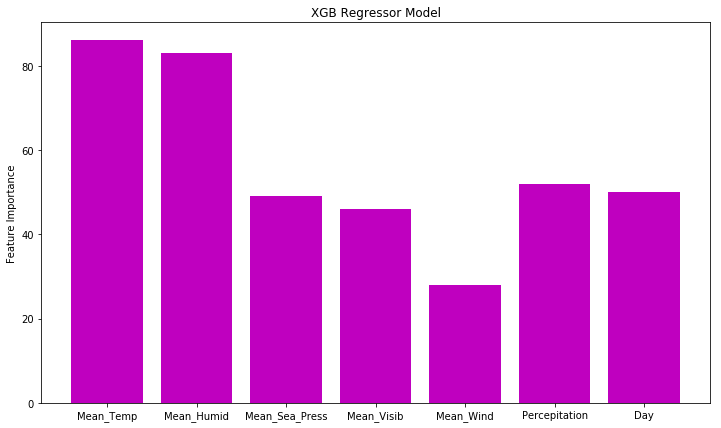

In [92]:
#Plotting feature importance as assigned by the XGB Regressor model
xgb3_L.fit(X,y)
feature_dict = xgb3_L.booster().get_fscore()
feature_values = [feature_dict[i] for i in feature_dict.keys()]

fig, ax = plt.subplots(figsize=(12,7))

plt.bar(range(len(features)),feature_values,color='m')
plt.xticks(range(len(features)),features)
plt.ylabel('Feature Importance')
plt.title('XGB Regressor Model')
plt.show()

R-squared for our XGB Regressor model

In [93]:
xgb3_L.score(X,y)

0.61692226402500894

Root Mean Squared Error for our XGB Regressor Model

In [94]:
RMSE = mean_squared_error(y,xgb3_L.predict(X))
print('RMSE:',MRSE)

MRSE: 10491.2293813
